In [ ]:
# !pip install -Uq diffusers ftfy accelerate

# !pip install -Uq git+https://github.com/huggingface/transformers 


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import torch, torchvision
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from diffusers import DDPMPipeline
from diffusers import DDIMScheduler
from datasets import load_dataset
from matplotlib import pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
dataset = load_dataset("images", split="train",data_dir="./")
dataset["image"]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=214x270 at 0x7FA4582188B0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=454x266 at 0x7FA45819B2E0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2033x1654 at 0x7FA45819B190>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x675 at 0x7FA45819B3A0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=172x270 at 0x7FA45819B370>]

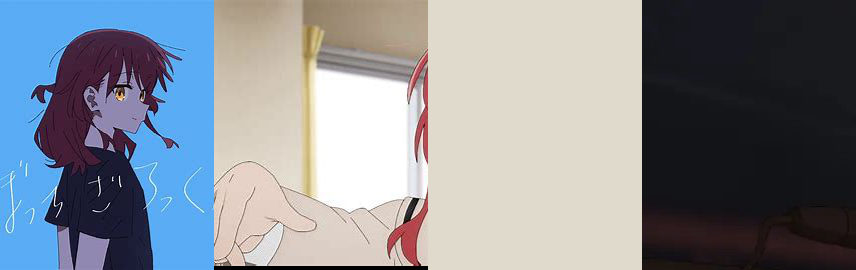

In [ ]:
# show 
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

In [ ]:
## instance prompt
name_of_your_concept = "ikuyo"  
type_of_thing = "anime girl" 
instance_prompt = f"an anime photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: an anime photo of ikuyo anime girl


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [ ]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

{'instance_images': tensor([[[-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941],
          [-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941],
          [-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941],
          ...,
          [-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941],
          [-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941],
          [-0.2941, -0.2941, -0.2941,  ..., -0.2941, -0.2941, -0.2941]],
 
         [[ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490],
          [ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490],
          [ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490],
          ...,
          [ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490],
          [ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490],
          [ 0.3490,  0.3490,  0.3490,  ...,  0.3490,  0.3490,  0.3490]],
 
         [[ 0.9216,  0.9216,  0.9216,  ...,  0.9216,  0.9216,  0.9216],
         

In [ ]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format)

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel
from diffusers import StableDiffusionPipeline
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained("DGSpitzer/Cyberpunk-Anime-Diffusion", subfolder="vae")
# unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
pipe = StableDiffusionPipeline.from_pretrained("DGSpitzer/Cyberpunk-Anime-Diffusion")
pipe = pipe.to("cuda")
unet = pipe.unet
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
learning_rate = 2e-06
max_train_steps = 400


In [ ]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # where to save the pipeline
)

In [ ]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


  0%|          | 0/400 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/accelerate/launchers.py:103 in notebook_launcher          │
│                                                                                                  │
│   100 │   │   │   print("Launching training on one GPU.")                                        │
│   101 │   │   else:                                                                              │
│   102 │   │   │   print("Launching training on one CPU.")                                        │
│ ❱ 103 │   │   function(*args)                                                                    │
│   104 │   else:                                                                                  │
│   105 │   │   if num_processes is None:                                                          │
│   106 │   │   │   raise ValueError(                                                              │
│ in training_function                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/accelerate/accelerator.py:1441 in backward                │
│                                                                                                  │
│   1438 │   │   elif self.scaler is not None:                                                     │
│   1439 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1440 │   │   else:                                                                             │
│ ❱ 1441 │   │   │   loss.backward(**kwargs)                                                       │
│   1442 │                                                                                         │
│   1443 │   def unscale_gradients(self, optimizer=None):                                          │
│   1444 │   │   """                                                                               │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/torch/_tensor.py:488 in backward                          │
│                                                                                                  │
│    485 │   │   │   │   create_graph=create_graph,                                                │
│    486 │   │   │   │   inputs=inputs,                                                            │
│    487 │   │   │   )                                                                             │
│ ❱  488 │   │   torch.autograd.backward(                                                          │
│    489 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    490 │   │   )                                                                                 │
│    491                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197 in backward                │
│                                                                                                  │
│   194 │   # The reason we repeat same the comment below is that                                  │
│   195 │   # some Python versions print out the first line of a multi-line function               │
│   196 │   # calls in the traceback and some print out the last line                              │
│ ❱ 197 │   Variable._execution_engine.run_backward(  # Calls

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# pipe = StableDiffusionPipeline.from_pretrained(
#     args.output_dir,
#     torch_dtype=torch.float16,
# ).to("cuda")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

In [ ]:
# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt = f"a photo of {name_of_your_concept} {type_of_thing} "

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 11

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

accelerate launch train_dreambooth.py --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" --instance_data_dir="images"  --output_dir="./"  --with_prior_preservation --prior_loss_weight=1.0 \
  --class_data_dir="./girls" --instance_prompt="a photo of anime girl" \
  --class_prompt="anime girl" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=800